# Transcript Analysis

In [51]:
%load_ext autoreload
%autoreload 2
import os
import re
import sys
import tqdm
import pickle
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

def find_transcripts(author_name):
	transcript_dir_path = '_Transcripts'
	print('  All Podcasts:')
	[print(f'    {dir}') for dir in os.listdir(transcript_dir_path) if os.path.isdir(os.path.join(transcript_dir_path, dir))]
	for dir in os.listdir(transcript_dir_path):
		# check if dir and if author_name is in dir
		if os.path.isdir(os.path.join(transcript_dir_path, dir)) and author_name in dir:
			print(f'Found {author_name} in {transcript_dir_path}/{dir}.')
			transcript_paths = []
			for file in sorted(os.listdir(os.path.join(transcript_dir_path, dir)), reverse=True):
				transcript_paths.append(os.path.join(transcript_dir_path, dir, file))
			print(f' Found {len(transcript_paths)} transcripts.')
			return transcript_paths
	print(' Transcript Path not Found author:', os.path.join(os.getcwd(), author_name))

def extract_yaml_front_matter(f, transcript_dict):
	# capture all the meta data until the next --- is found
	meta_data = ''
	meta_dict = defaultdict(str)
	for line in f:
		if line == '---\n':
			break
		meta_data += line
	# extract all the information with 'header' : 'value' format
	meta_data = meta_data.split('\n')
	for data in meta_data:
		if data != '':
			header, value = data.split(': ')
			meta_dict[header] = value
	return meta_dict

def read_transcript(transcript_name, transcript_dict):
	with open(transcript_name, 'r') as f:
		print(f'  Reading: {transcript_name}')
		meta_flag = False
		meta_dict = defaultdict(str)
		for line in f:
			# read the .md meta data in YAML Front Matter format --- 
			if line == '---\n' and not meta_flag:
				meta_dict = extract_yaml_front_matter(f, transcript_dict)
				meta_flag = True
			# title is the first line of the transcript, with # at the beginning
			elif line[0] == '#':
				meta_flag = False
				title = line[1:].strip()
			# date is in the second line of the transcript, between [ and ]
			# url is in the second line of the transcript, between ( and )
			elif line[:2] == '**':
				date = re.search(r'\[(.*?)\]', line).group(1)
				# conver date to datetime (December 6, 2023 -> 2023-12-06)
				date = datetime.datetime.strptime(date, '%B %d, %Y').strftime('%Y-%m-%d')
				# add year, month, day to the dict
				year = date[:4]
				month = date[5:7]
				day = date[8:]
				transcript_dict[title]['date'] = date
				transcript_dict[title]['year'] = year
				transcript_dict[title]['month'] = month
				transcript_dict[title]['day'] = day
				transcript_dict[title]['date'] = date
				# convert date to day of the week
				weekday = datetime.datetime.strptime(date, '%Y-%m-%d').strftime('%A')
				transcript_dict[title]['weekday'] = weekday
				url = re.search(r'\((.*?)\)', line).group(1)
				transcript_dict[title]['url'] = url
			elif not meta_flag:
				# add the line to the transcript (taking out leading * and other formatting including ' and ")
				transcript_dict[title]['transcript'].append(str(line[3:].strip()))
		if len(meta_dict) > 0:
			for key, value in meta_dict.items():
				transcript_dict[title][key] = value
		return transcript_dict

def dict_to_pandas(transcript_dict):
	# initialize the dataframe
	transcript_df = pd.DataFrame()
	for title, content in transcript_dict.items():
		# add the title to the content at the beginning
		content['title'] = title
		transcript_df = pd.concat([transcript_df, pd.DataFrame([content])], ignore_index=True)
	# sort by year, month, day and reset the index
	transcript_df = transcript_df.sort_values(by=['year', 'month', 'day'], ascending=False, ignore_index=True)
	# move Title to the front of the dataframe
	cols = transcript_df.columns.tolist()
	cols = cols[-1:] + cols[:-1]
	transcript_df = transcript_df[cols]
	# transcript_df['Video Views'] = transcript_df['Video Views'].str.replace(',', '').astype(int)
	return transcript_df

def pickle_transcript_df(transcript_df, author_name):
	print(f'Pickling {author_name} transcript_df.')
	dataframe_dir_path = '_Dataframes'
	if not os.path.exists(dataframe_dir_path):
		os.makedirs(dataframe_dir_path)
	transcript_df_name = f'{author_name}_transcript_df.pickle'
	df_path = os.path.join(dataframe_dir_path, transcript_df_name)
	with open(df_path, 'wb') as f:
		pickle.dump(transcript_df, f)
		print(f' Pickled {transcript_df_name} in {dataframe_dir_path}/.')

def dataframe_exists(author_name):
	dataframe_dir_path = '_Dataframes'
	for file in os.listdir(dataframe_dir_path):
		if author_name in file:
			return True
	return False

def main(author_name = 'New York Times', reload=True, save_df=False):
	# author_name = sys.argv[1]
	print(f'Searching for {author_name} transcripts...')
	# check if the dataframe exists
	if dataframe_exists(author_name) and not reload:
		print(f'Found: transcript_df already exists.')
		dataframe_dir_path = os.path.join('_Dataframes', f'{author_name}_transcript_df.pickle')
		print(f'  Loading \'{dataframe_dir_path}\'...')
		with open(dataframe_dir_path, 'rb') as f:
			transcript_df = pickle.load(f)
			print(f'  Number of transcripts: {len(transcript_df)}.')
		return transcript_df
	# if the dataframe does not exist, create it by reading the transcripts
	transcripts = find_transcripts(author_name)
	transcript_dict = defaultdict(lambda: defaultdict(list))
	for transcript in transcripts:
		if '.md' in transcript:
			read_transcript(transcript, transcript_dict)
	transcript_df = dict_to_pandas(transcript_dict)
	if save_df:
		pickle_transcript_df(transcript_df, author_name)
	return transcript_df
	
author_name = 'Bill Simmons NBA'
transcript_df = main(author_name)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Searching for Bill Simmons NBA transcripts...
  All Podcasts:
    Andrew Huberman
    Bill Simmons
    Bill Simmons NBA
    Bill Simmons NFL
    Brain Inspired
    Cognitive Revolution How AI Changes Everything
    Democracy Now
    Democracy Now Headlines
    Lex Fridman
    New York Times Podcasts
    The Wall Street Journal
Found Bill Simmons NBA in _Transcripts/Bill Simmons NBA.
 Found 172 transcripts.
  Reading: _Transcripts\Bill Simmons NBA\20240510_Bill Simmons NBA.md
  Reading: _Transcripts\Bill Simmons NBA\20240508_Bill Simmons NBA.md
  Reading: _Transcripts\Bill Simmons NBA\20240506_Bill Simmons NBA.md
  Reading: _Transcripts\Bill Simmons NBA\20240505_Bill Simmons NBA.md
  Reading: _Transcripts\Bill Simmons NBA\20240502_Bill Simmons NBA.md
  Reading: _Transcripts\Bill Simmons NBA\20240501_Bill Simmons NBA.md
  Reading: _Transcripts\Bill Simmons NBA\20240430_Bill Simmons NBA.md
  Reading: _

In [52]:
# reverse the order of the x-axis
transcript_df = transcript_df.sort_values(by='date', ascending=False, ignore_index=True)
transcript_df

,title,date,year,month,day,weekday,url,transcript,Date Generated,Transcription Model,Length,Video Keywords,Video Views,Video Rating
0,Bill Simmons’s “I Hate to Tell You” NBA Truths...,2024-05-10,2024,05,10,Friday,https://www.youtube.com/watch?v=G_NQ3Ngo8NA,"[All right, let's play the game that I mention...","May 12, 2024",whisper medium 20231117,1308s,"['The Ringer', 'Ringer NBA', 'NBA Show', 'NBA ...",92515,None
1,Is the NBA Product More or Less Valuable Than ...,2024-05-08,2024,05,08,Wednesday,https://www.youtube.com/watch?v=WPUZw1OA8Jw,"[All right., The king of substack, Ethan Sherw...","May 12, 2024",whisper medium 20231117,3007s,"['The Ringer', 'Ringer NBA', 'NBA Show', 'NBA ...",55334,None
2,A New Coach Isn’t Fixing LeBron and the Lakers...,2024-05-06,2024,05,06,Monday,https://www.youtube.com/watch?v=xRFp4dH0fjQ,"[This is the toughest., What do you do?, Becau...","May 12, 2024",whisper medium 20231117,2558s,"['The Ringer', 'Ringer NBA', 'NBA Show', 'NBA ...",93433,None
3,Nuggets vs. Timberwolves is the Series We've B...,2024-05-05,2024,05,05,Sunday,https://www.youtube.com/watch?v=sr1gS4jSQlk,[Where do you want to start with Minnesota Den...,"May 12, 2024",whisper medium 20231117,1944s,"['NBA Playoffs', 'NBA Reactions', 'Bill Simmon...",101264,None
4,NBA Knicks Vs. 76ers Game 6 LIVE Reaction with...,2024-05-02,2024,05,02,Thursday,https://www.youtube.com/watch?v=KAgd4UrEfz8,[and then you watch a game like tonight and Le...,"May 12, 2024",whisper medium 20231117,3865s,"['NBA Playoffs', 'NBA Reactions', 'Bill Simmon...",51365,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,Debunking the Lies in the Tim Donaghy NBA Bett...,2022-09-25,2022,09,25,Sunday,https://www.youtube.com/watch?v=70KE1NHxXAQ,[All right. So I've made a point not to talk a...,"May 13, 2024",whisper medium 20231117,2018s,"['Bill Simmons', 'Bill Simmons podcast', 'NBA ...",209401,None
168,Disastrous Season in Store for the Nets? | The...,2022-09-21,2022,09,21,Wednesday,https://www.youtube.com/watch?v=mrN4QWfRx2M,"[We're four weeks away., This has the potentia...","May 13, 2024",whisper medium 20231117,535s,"['The Ringer', 'Bill Simmons Podcast', 'Bill S...",60749,None
169,Should the Knicks Have Traded for Donovan Mitc...,2022-09-06,2022,09,06,Tuesday,https://www.youtube.com/watch?v=HQJZXYklQ8w,[I guess the one thing I was surprised by was ...,"May 13, 2024",whisper medium 20231117,560s,"['bill simmons', 'ryen russillo', 'the ringer'...",82681,None
170,Are the Cavaliers True Contenders With the Add...,2022-09-02,2022,09,02,Friday,https://www.youtube.com/watch?v=5daH5EjvQm0,[I want to start with Cleveland because I thou...,"May 13, 2024",whisper medium 20231117,552s,"['Bill Simmons Podcast', 'The Ringer', 'Ryen R...",107748,None


In [53]:
from utils import fuzzy_lookup

def check_for_fuzzy_columns(transcript_df, target_word_list):
	filtered_target_word_list = []
	exclusion_list = []
	for word in target_word_list:
		if f'max_fuzzy_{word}' in transcript_df.columns:
			exclusion_list.append(word)
			# remove the word from the target_word_list
		else:
			filtered_target_word_list.append(word)
	print(f'Excluding the following words already in the dataset: ')
	print(f'  {exclusion_list}')
	return filtered_target_word_list

def topic_search(transcript_df, target_word_list, fuzzy_threshold):
	print('Performing fuzzy search for the following words:')
	print(f'  {target_word_list}')
	# check to see if the target words are already in the transcript_df
	target_word_list_filtered = check_for_fuzzy_columns(transcript_df, target_word_list)
	max_fuzzy_list = defaultdict(list)
	max_fuzzy_word_list = defaultdict(list)

	for idx, transcript in enumerate(transcript_df['transcript']):
		pod_title = transcript_df.iloc[idx]['title']	
		pod_date = transcript_df.iloc[idx]['year'] + '-' + transcript_df.iloc[idx]['month'] + '-' + transcript_df.iloc[idx]['day']
		print(f'{pod_date}: {pod_title}')
		for t_index, target_word in enumerate(target_word_list_filtered):
			max_fuzzy, max_fuzzy_word = fuzzy_lookup.fuzzy_matching(target_word, transcript, fuzzy_threshold)
			max_fuzzy_list[target_word].append(max_fuzzy)
			max_fuzzy_word_list[target_word].append(max_fuzzy_word)
	# add the max_fuzzy and max_fuzzy_word to the transcript_df
	for key in max_fuzzy_list.keys():
		transcript_df[f'max_fuzzy_{key}'] = max_fuzzy_list[key]
		transcript_df[f'max_fuzzy_word_{key}'] = max_fuzzy_word_list[key]
	return transcript_df


# perform fuzzy match for all words in target_word_list
target_word_list = ['lakers', 'clippers', 'warriors', 'suns', 'kings', 'mavericks', 'rockets', 'grizzlies', 'pelicans', 'spurs', 'timberwolves', 'thunder', 'nuggets', 'jazz', 'blazers',
								 'heat', 'magic', 'wizards', 'hawks', 'hornets', 'nets', 'celtics', 'knicks', '76ers', 'bucks', 'pacers', 'pistons', 'bulls', 'cavaliers', 'raptors']
fuzzy_threshold = 0.85
transcript_df = topic_search(transcript_df, target_word_list, fuzzy_threshold)


Performing fuzzy search for the following words:
  ['lakers', 'clippers', 'warriors', 'suns', 'kings', 'mavericks', 'rockets', 'grizzlies', 'pelicans', 'spurs', 'timberwolves', 'thunder', 'nuggets', 'jazz', 'blazers', 'heat', 'magic', 'wizards', 'hawks', 'hornets', 'nets', 'celtics', 'knicks', '76ers', 'bucks', 'pacers', 'pistons', 'bulls', 'cavaliers', 'raptors']
Excluding the following words already in the dataset: 
  []
2024-05-10: Bill Simmons’s “I Hate to Tell You” NBA Truths | The Bill Simmons Podcast
  "lakers" Match Score: 1.0    | Match: Lakers
  "clippers" Match Score: 0.6154 | Match: chips
  "warriors" Match Score: 0.6154 | Match: worse
  "suns" Match Score: 0.8    | Match: sounds
  "kings" Match Score: 0.7273 | Match: making
  "mavericks" Match Score: 0.5714 | Match: makes
  "rockets" Match Score: 0.625  | Match: producers
  "grizzlies" Match Score: 0.6667 | Match: Rileys
  "pelicans" Match Score: 0.6667 | Match: plan
  "spurs" Match Score: 0.7273 | Match: sports
  "timberw

In [8]:
# pickle the transcript_df
pickle_transcript_df(transcript_df, author_name = author_name)
transcript_df

Pickling New York Times transcript_df.
 Pickled New York Times_transcript_df.pickle in _Dataframes/.


,title,date,year,month,day,weekday,url,transcript,Date Generated,Transcription Model,Length,Video Keywords,Video Views,Video Rating,max_fuzzy_lakers,max_fuzzy_word_lakers,max_fuzzy_celtics,max_fuzzy_word_celtics
0,Is the NBA Product More or Less Valuable Than ...,2024-05-08,2024,05,08,Wednesday,https://www.youtube.com/watch?v=WPUZw1OA8Jw,"[All right., The king of substack, Ethan Sherw...","May 09, 2024",whisper medium 20231117,3007s,"['The Ringer', 'Ringer NBA', 'NBA Show', 'NBA ...",32999,None,1.000000,Lakers,1.000000,Celtics
1,NBA Magic Vs. Cavaliers Game 7 LIVE Playoffs R...,2024-05-05,2024,05,05,Sunday,https://www.youtube.com/watch?v=YfihPmBMG7Q,"[Okay., uz, He really, really, really gives a ...","May 05, 2024",whisper medium 20231117,4890s,"['NBA Playoffs', 'NBA Reactions', 'Bill Simmon...",34463,None,1.000000,Lakers,1.000000,Celtics
2,NBA Knicks Vs. 76ers Game 6 LIVE Reaction with...,2024-05-02,2024,05,02,Thursday,https://www.youtube.com/watch?v=KAgd4UrEfz8,[and then you watch a game like tonight and Le...,"May 03, 2024",whisper medium 20231117,3865s,"['NBA Playoffs', 'NBA Reactions', 'Bill Simmon...",35805,None,1.000000,Lakers,1.000000,Celtics
3,Is This Suns Experiment Over? | The Bill Simmo...,2024-04-24,2024,04,24,Wednesday,https://www.youtube.com/watch?v=fCf-R6h-AVI,"[All right. So sons wolves, the crazy ownershi...","April 25, 2024",whisper medium 20231117,1107s,"['The Ringer', 'Ringer NBA', 'NBA Show', 'NBA ...",59577,None,0.769231,players,1.000000,Celtics
4,Jokic’s Place in the Pantheon If He Goes Back-...,2024-04-22,2024,04,22,Monday,https://www.youtube.com/watch?v=8kSjxWTAkcs,[I was thinking about this Jokic for your run....,"April 23, 2024",whisper medium 20231117,496s,"['The Ringer', 'Ringer NBA', 'NBA Show', 'NBA ...",25388,None,1.000000,Lakers,0.545455,this
5,NBA Playoffs Rd. 1 LIVE Reaction with Bill Sim...,2024-04-21,2024,04,21,Sunday,https://www.youtube.com/watch?v=Pzxb3-m1gpU,[Then you watch a game like tonight and LeBron...,"April 22, 2024",whisper medium 20231117,4580s,"['NBA Playoffs', 'NBA Reactions', 'Bill Simmon...",47960,None,1.000000,Lakers,1.000000,Celtics
6,76ers-Knicks Playoff Preview | The Bill Simmon...,2024-04-18,2024,04,18,Thursday,https://www.youtube.com/watch?v=RCWrUrqCMEI,"[All right, I've known Chris Ryan since 2011. ...","April 19, 2024",whisper medium 20231117,1602s,"['The Ringer', 'Ringer NBA', 'NBA Show', 'NBA ...",13933,None,1.000000,lakers,1.000000,celtics
7,Bill and Ryen’s All-NBA Teams | The Bill Simmo...,2024-04-15,2024,04,15,Monday,https://www.youtube.com/watch?v=3-LqCNqs2Q8,"[First team, OMBA. So I guess we have the same...","April 18, 2024",whisper medium 20231117,1399s,"['The Ringer', 'Ringer NBA', 'NBA Show', 'NBA ...",48510,None,1.000000,Lakers,1.000000,Celtics
8,Why It's Likely That Bronny James Will Get Dra...,2024-04-08,2024,04,08,Monday,https://www.youtube.com/watch?v=ESsDxVG1rFo,[Will a team draft Bronnie James to go after L...,"April 15, 2024",whisper medium 20231117,525s,"['Bronny James', 'Lebron James Jr.', 'Lebron J...",61979,None,1.000000,Lakers,0.545455,This


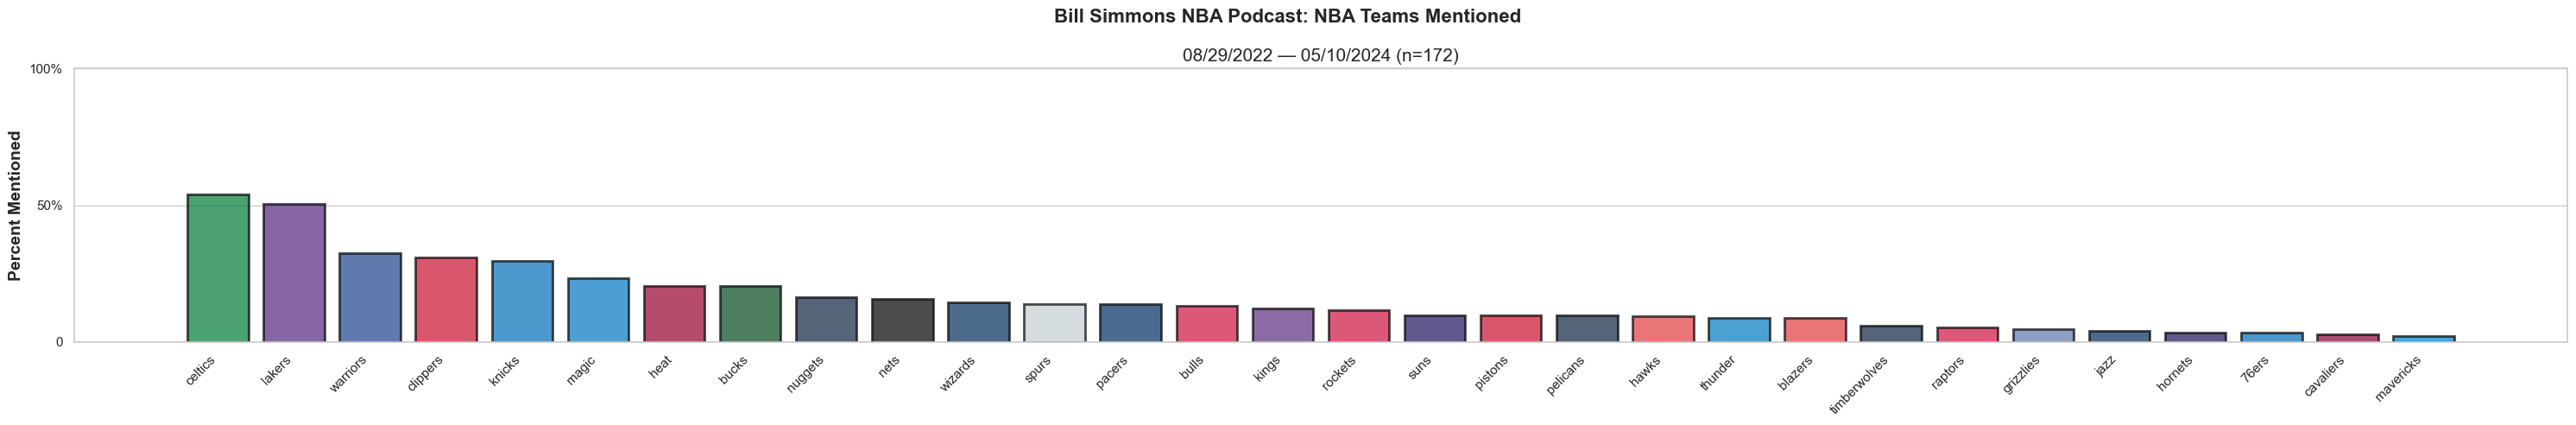

In [71]:
team_colors = {
    'lakers': '#552583',          # Purple and Gold
    'clippers': '#C8102E',        # Red and Blue
    'warriors': '#1D428A',        # Royal Blue and Gold
    'suns': '#1D1160',            # Purple, Orange, and Black
    'kings': '#5A2D81',           # Purple, Silver, and Black
    'mavericks': '#007DC5',       # Royal Blue, Navy Blue, and Silver
    'rockets': '#CE1141',         # Red and Silver
    'grizzlies': '#5D76A9',       # Navy Blue, Beige, and Slate Blue
    'pelicans': '#0C2340',        # Navy Blue, Gold, and Red
    'spurs': '#C4CED4',           # Silver, Black, and White
    'timberwolves': '#0C2340',    # Navy Blue, Lake Blue, and White
    'thunder': '#007AC1',         # Blue, Orange, and Yellow
    'nuggets': '#0E2240',         # Navy Blue, Gold, and Sky Blue
    'jazz': '#002B5C',            # Navy Blue, Gold, and Green
    'blazers': '#E03A3E',         # Red, Black, and White
    'heat': '#98002E',            # Red, Black, and White
    'magic': '#0077C0',           # Royal Blue, Silver, and Black
    'wizards': '#002B5C',         # Navy Blue, Red, and Silver
    'hawks': '#E03A3E',           # Red, Black, and Silver
    'hornets': '#1D1160',         # Purple, Teal, and White
    'nets': '#000000',            # Black and White
    'celtics': '#007A33',         # Green and White
    'knicks': '#006BB6',          # Royal Blue, Orange, and Silver
    '76ers': '#006BB6',           # Royal Blue, Red, and White
    'bucks': '#00471B',           # Hunter Green, Cream, and White
    'pacers': '#002D62',          # Navy Blue, Gold, and White
    'pistons': '#C8102E',         # Red, Blue, and White
    'bulls': '#CE1141',           # Red, Black, and White
    'cavaliers': '#860038',       # Wine, Gold, and Navy Blue
    'raptors': '#CE1141'          # Red, Black, and Silver
}

sns.set_theme(style="whitegrid")
plt.figure(figsize=(len(target_word_list), 5))

# add a column for the number of shows mentioned for each topic
for t_idx, topic in enumerate(target_word_list):
	# find the number of rows with max_fuzzy > 0.9 for the host
	topic_df = transcript_df[transcript_df[f'max_fuzzy_{topic}'] > 0.9]

# for each host find the number of rows with max_fuzzy > 0.9 and plot
num_mentions = []
for t_idx, topic in enumerate(target_word_list):
	# find the number of rows with max_fuzzy > 0.9 for the host
	topic_df = transcript_df[transcript_df[f'max_fuzzy_{topic}'] > 0.9]
	num_shows = topic_df.shape[0]/len(transcript_df)
	num_mentions.append(num_shows)

# sort the target_word_list by the number of shows mentioned
sorted_target_word_list = [x for _, x in sorted(zip(num_mentions, target_word_list), reverse=True)]
num_mentions = sorted(num_mentions, reverse=True)
# sort colors by the sorted target_word_list 
team_colors = {key: team_colors[key] for key in sorted_target_word_list}

plt.bar(range(len(target_word_list)), num_mentions, color=team_colors.values(), alpha=0.7, edgecolor='black', linewidth=2)
plt.ylim(0, 1)
plt.xticks(range(len(sorted_target_word_list)), sorted_target_word_list)
plt.yticks([0, 0.5, 1], ['0', '50%', '100%'])
# rotate the x-axis labels
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percent Mentioned', fontsize=14, fontweight='bold')
plt.suptitle(f'{author_name} Podcast: NBA Teams Mentioned', fontsize=16, fontweight='bold')
# convert to mm/DD/YYYY
first_date = datetime.datetime.strptime(transcript_df['date'].iloc[-1], '%Y-%m-%d').strftime('%m/%d/%Y')
last_date = datetime.datetime.strptime(transcript_df['date'].iloc[0], '%Y-%m-%d').strftime('%m/%d/%Y')
plt.title(f'{first_date} — {last_date} (n={len(transcript_df)})', fontsize=15)
# reduce distance between sup and title
# only keep horizontal grid
plt.grid(axis='x')
# tight layout
plt.tight_layout()

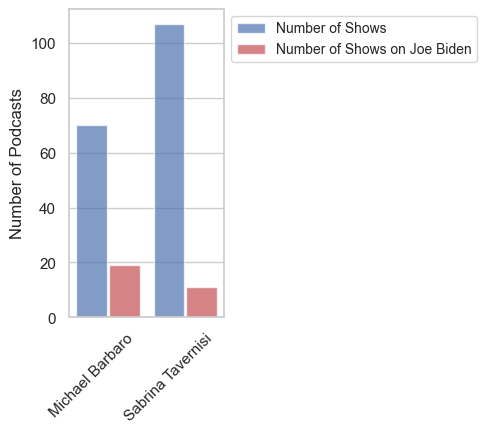

In [28]:
# make a grouped bar plot for the number of rows with 'Michael Barbaro' vs. 'Sabrina Tavern' with max_fuzzy > 0.9
# and the number of rows with the topic word with max_fuzzy > 0.9
# make a plot as to the number of rows with 'Michael Barbaro' vs. 'Sabrina Tavern' with max_fuzzy > 0.9
sns.set_theme(style="whitegrid")
plt.figure(figsize=(2, 4))
hosts = target_word_list[:2]
topic = target_word_list[4]
# for each host find the number of rows with max_fuzzy > 0.9 and plot
for h_idx, host in enumerate(hosts):
	spacing = 0
	if h_idx > 0:
		spacing = 1
	# find the number of rows with max_fuzzy > 0.9 for the host
	host_df = transcript_df[transcript_df[f'max_fuzzy_{host}'] > 0.85]
	# find the number of rows with max_fuzzy > 0.9 for the topic
	topic_df = host_df[host_df[f'max_fuzzy_{topic}'] > 0.85]
	num_shows = host_df.shape[0]
	num_shows_topic = topic_df.shape[0]
	# plot as double bar graph with host and topic
	if h_idx == 0:
		plt.bar(h_idx+spacing, num_shows, color='b', alpha=0.7, label='Number of Shows')
		plt.bar(h_idx+spacing+0.85, num_shows_topic, color='r', alpha=0.7, label=f'Number of Shows on {topic}')
	else:
		plt.bar(h_idx+spacing, num_shows, color='b', alpha=0.7)
		plt.bar(h_idx+spacing+0.85, num_shows_topic, color='r', alpha=0.7)
plt.xticks([0, 2], hosts)
# rotate the x-axis labels
plt.xticks(rotation=45)
# legend outside of box outer right and smaller font size using bbox_to_anchor
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.ylabel('Number of Podcasts')
# only keep horizontal grid
plt.grid(axis='x')